<br><h1 style="font-family:times new roman"><center>Model Creation</center></h1>

This is the main file that is used to train, test and evaluate different models. This file performs the following steps:
1. Load the saved and prepared dataset.
2. Split the data into training, validation and testing datasets.
3. Train 3 different models – CNN only, GRU only and combination of CNN and GRU.
4. Test and Evaluate different metrics for the above models.

In [1]:
import logging
import os
from time import time
import numpy as np
from tensorflow import keras
from scripts.metrics import Metrics
from scripts.model_usage import ModelBuilder, Trainer
from scripts.utils import load_and_split_data, plot_histories

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# Suppress TensorFlow logging
logging.getLogger("tensorflow").setLevel(logging.FATAL)


–––––––––––––––––––––––––
Training model: CNN
–––––––––––––––––––––––––

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 49.
Test Loss: 0.6778
Test Accuracy: 0.8746

Classification Report for CNN:

              precision    recall  f1-score   support

         D01       0.85      0.84      0.85       380
         D02       0.96      0.97      0.97       254
         D03       0.91      0.89      0.90       534
         D04       0.82      0.86      0.84       275
         D05       0.81      0.85      0.83       122
         D06       0.87      0.87      0.87       158
         D07       0.70      0.75      0.72       118
         D08       0.77      0.72      0.74        46
         D09       0.85      0.78      0.81        94
         D10       0.93      0.97      0.95       177
         D11       0.91      0.89      0.90       274

    accuracy                           0.87      2432
   macro av

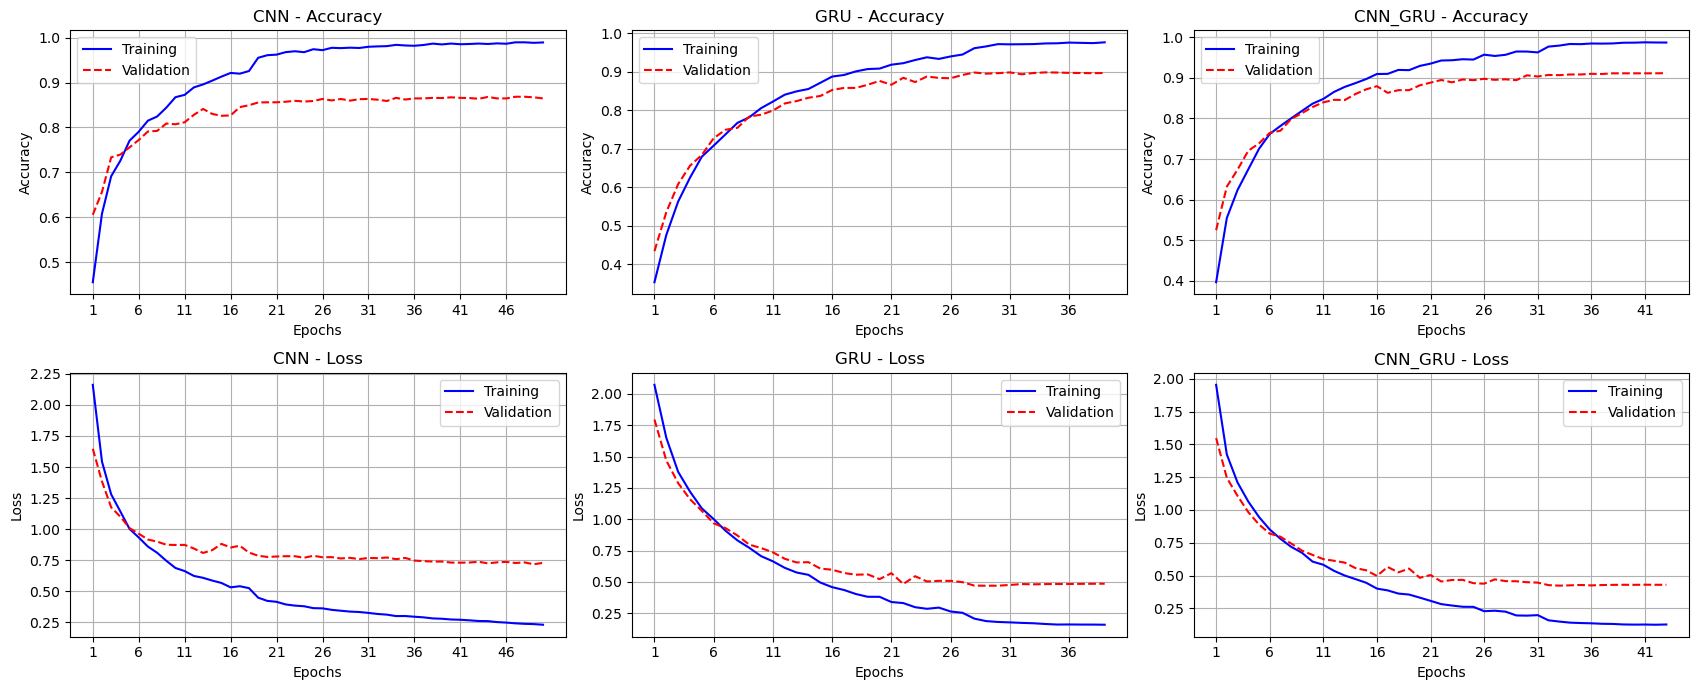

In [2]:
# Load and preprocess data
x_train, x_val, x_test, y_train, y_val, y_test, label_to_id, n_labels = (
    load_and_split_data()
)

# Build models
input_shape = x_train.shape[1:]
model_builder = ModelBuilder(input_shape=input_shape, n_labels=n_labels)
models = model_builder.build_models()

# Initialise metrics collection
metrics = Metrics()
histories = []
model_names = []

# Hyperparams
EPOCHS = 50
BATCH_SIZE = 128

# For each model, compile, train, and evaluate
for model_name, model in models.items():
    print(f'\n{"–" * 25}')
    print(f"Training model: {model_name}")
    print("–" * 25)
    trainer = Trainer(model, model_name)
    trainer.compile_model()

    # Measure training time
    start_time = time()
    history = trainer.train_model(
        x_train, y_train, x_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE
    )
    training_time = time() - start_time

    # Measure testing time
    start_time = time()
    test_loss, test_acc = trainer.evaluate_model(x_test, y_test)
    testing_time = time() - start_time

    # Generate predictions
    y_pred_probs = trainer.predict(x_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Calculate and update metrics
    metrics.calculate_metrics(
        model_name,
        y_test,
        y_pred_classes,
        label_to_id,
        training_time,
        testing_time,
        EPOCHS,
    )

    histories.append(history)
    model_names.append(model_name)

    trainer.save_model()

    # Clear the backend session to free up resources
    keras.backend.clear_session()

# Display and save results
metrics.display_metrics()
plot_histories(histories, model_names, figsize=(17, 7))

Based on the results, we can say the following:
1. The CNN+GRU model has the highest accuracy and is faster than the GRU-only model, which achieved nearly similar performance.
2. The CNN-only model is the fastest in both training and testing, but it has much lower accuracy (only 87.5%).
3. In the best model (CNN+GRU), the activities D07 (Stumble while walking) and D08 (Gently jump without falling) scored the lowest, and the model doesn't do well with these activities.
4. The model was trained on sequence of 150 samples of data, which is about 3 seconds at a rate of 50Hz. So, once an activity ends, we need at least 3 seconds of data to make a prediction (though we can use less data with padding, it might not perform well), plus about 1 extra second for the prediction itself.